In [1]:
import sys
sys.path.append("..")

## Statistical Analysis Week

#### Meeting summary notes:

| Topic | MM's Suggestion | Rationale |
| :--- | :--- | :--- |
| **Noise Reduction** | **Bin the x-axis** (e.g., wave height), then compute the **average** and **Standard Error** (or standard deviation) of the Setup ($\eta$) within each bin. | This process, often called **bin-averaging**, reduces scatter (noise) in the data points, making the underlying relationship between the independent variable ($x$) and Setup ($y$) clearer. |
| **Wavelength ($L_0$) Calculation** | Use a **weighted mean** of the frequencies in the **Sea-Swell (SS) band** to determine the characteristic frequency (and thus $L_0$). | The weighting factor should be the Power Spectral Density (PSD) at each frequency. The characteristic frequency, $f_{char}$, is: <br> $f_{char} = \frac{\sum (f \cdot PSD(f))}{\sum PSD(f)}$ <br> This is essentially the **mean frequency** of the wave energy spectrum, providing a more robust $L_0$ than just using the peak period. |
| **Non-Linear Regression** | Explore the relationship $\eta = aH_0^bL_0^c$ using the **Greedy Method** (or log-linear regression) described in a paper by Monismith. | This transformation turns the non-linear power-law equation into a linear equation: <br> $\log_{10}(\eta) = \log_{10}(a) + b \log_{10}(H_0) + c \log_{10}(L_0)$ <br> You can then use **standard multiple linear regression** to find the best-fit coefficients for $\log_{10}(a)$, $b$, and $c$. |

#### Last week's code:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.spectra import sensor_spectra
from src.bulk_parameters import Hs_band, compute_H0

# load data #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

# 1. 30 minute spectral averages#
nperseg= 3600 // 2 # 30 min at 1hz intervals

S1 = sensor_spectra(df1, nperseg=nperseg)
S6 = sensor_spectra(df6, nperseg=nperseg)

# 2. backrefract to compute H0
df_waves = compute_H0(S6, fmin=0.04, fmax=0.33)
H0_ser = pd.Series(df_waves['H0'], index=pd.to_datetime(df_waves.index)).sort_index()

# 3. Calculate Setup from RAW data
# Use the original high-freq dataframes where you know timestamps are correct
# We resample to 1-min averages first to reduce noise, then subtract
raw_h1, raw_h6 = df1['h'].resample('1min').mean() , df6['h'].resample('1min').mean()

# Align the raw data
# This handles any start-time differences or missing data automatically
aligned_df = pd.merge_asof(
    raw_h1.sort_index().to_frame('h1'),
    raw_h6.sort_index().to_frame('h6'),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=5)
).dropna()
# compute cross shore setup n 
# n = (Shore - Mean_Shore) - (Offshore - Mean_Offshore)
p1, p6 = aligned_df['h1'] - aligned_df['h1'].mean(), aligned_df['h6'] - aligned_df['h6'].mean()
n_raw = p1 - p6  



In [24]:

# # 4. Map the calculated setup to wave timestamps
H0_df = H0_ser.to_frame(name='H0').sort_index()
n_df = n_raw.to_frame(name='n').sort_index()
# Merge setup onto the wave timestamps
final_df = pd.merge_asof(
    H0_df,
    n_df,
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30) # Grab the setup closest to the spectral burst
).dropna()

# 5. Align tide series to the existing spectral data
# demeaned tide
tide = df6['h_tide'] - df6['h_tide'].mean()
# merge tide onto the aligned df
final_df = pd.merge_asof(
    final_df,                    # The dataframe with H0 and n
    tide,   # The tide data
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30) 
).dropna()

# check if 'Tp is already in final ddf to avoid 'run twice' errors
if 'Tp' not in final_df.columns:
    # extract Tp from S6 spectra
    if 'Seta' in S6:
        fp_xarray = S6['Seta'].idxmax(dim='frequency')
        Tp_ser = (1 / fp_xarray).to_series().rename('Tp')
        # merge Tp onto final df
        final_df = pd.merge_asof(
        final_df,                    # The dataframe with H0 and n
        Tp_ser.sort_index().to_frame(),   # The tide data
        left_index=True,
        right_index=True,
        direction='nearest',
        tolerance=pd.Timedelta(minutes=30) )

# compute L0, dw wavelength
g = 9.81
final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)


# extract variables for plotting
H0_plot   = final_df['H0']
n_plot    = final_df['n']
tide_plot = final_df['h_tide']

print(f"Final data points: {len(final_df)}")


Final data points: 3309


In [25]:
final_df

,H0,n,h_tide,Tp,L0
time,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,2.004463,6.273144
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,2.002233,6.259196
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,2.008937,6.301180
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,2.006698,6.287139
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,2.027036,6.415227
...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,2.004463,6.273144
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,2.008937,6.301180
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,2.002233,6.259196


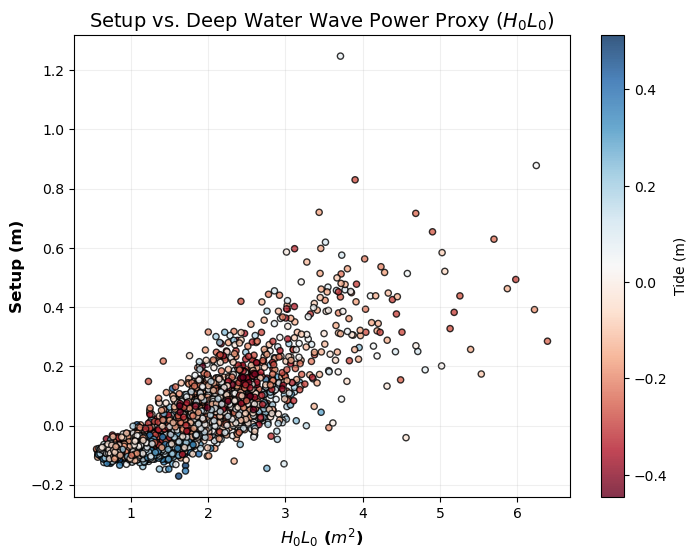

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sc = ax.scatter(final_df['H0'], final_df['n'], 
                c=final_df['h_tide'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)

ax.set_xlabel(r"$H_0 L_0$ ($m^2$)", fontsize=12, fontweight='bold')
ax.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax.set_title("Setup vs. Deep Water Wave Power Proxy ($H_0 L_0$)", fontsize=14)
ax.grid(True, alpha=0.2)
plt.colorbar(sc, label="Tide (m)")
plt.show()

#### Bin Averaging

In [30]:
final_df

,H0,n,h_tide,Tp,L0
time,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,2.004463,6.273144
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,2.002233,6.259196
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,2.008937,6.301180
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,2.006698,6.287139
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,2.027036,6.415227
...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,2.004463,6.273144
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,2.008937,6.301180
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,2.002233,6.259196


In [34]:
## script for bin averaging ##

def bin_stats(df, x_col, y_col, bin_size, min_points = 5):
    # Work on a copy to avoid SettingWithCopy warnings
    data = df[[x_col, y_col]].copy().dropna()
    
    # Determine the bin edges
    if bin_size is not None:
        # Create bins of fixed size from min to max
        start = np.floor(data[x_col].min())
        end = np.ceil(data[x_col].max())
        bins = np.arange(start, end + bin_size, bin_size)
    else:
        # Use simple linearly spaced bins
        bins = np.linspace(data[x_col].min(), data[x_col].max(), num_bins + 1)
        
    # Create a new column identifying which bin each row belongs to
    # We use pd.cut to assign the bin
    data['bin_group'] = pd.cut(data[x_col], bins=bins, include_lowest=True)
    
    # Group by the bin and calculate statistics
    stats = data.groupby('bin_group', observed=True).agg(
        x_mean = (x_col, 'mean'),  # Center of gravity for X
        y_mean = (y_col, 'mean'),  # Mean of Y
        y_std  = (y_col, 'std'),   # Std Dev of Y
        count  = (y_col, 'count')  # Number of points
    )
    
    # Calculate Standard Error of the Mean (SEM)
    # SEM = std / sqrt(N)
    stats['y_sem'] = stats['y_std'] / np.sqrt(stats['count'])
    
    # Filter out empty bins or bins with too few points to be statistically useful
    stats = stats[stats['count'] >= min_points].reset_index(drop=True)
    
    return stats

     x_mean    y_mean     y_std  count     y_sem
0  0.576098 -0.090554  0.011189      8  0.003956
1  0.658773 -0.089376  0.013597     77  0.001550
2  0.751944 -0.085279  0.017908    117  0.001656
3  0.848764 -0.081251  0.018028    102  0.001785
4  0.952826 -0.076940  0.019946    173  0.001516


<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_63952/1152992568.py:29: SyntaxWarning: invalid escape sequence '\p'
  label='Binned Avg $\pm$ SEM'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_63952/1152992568.py:33: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Setup $\eta$ (m)')


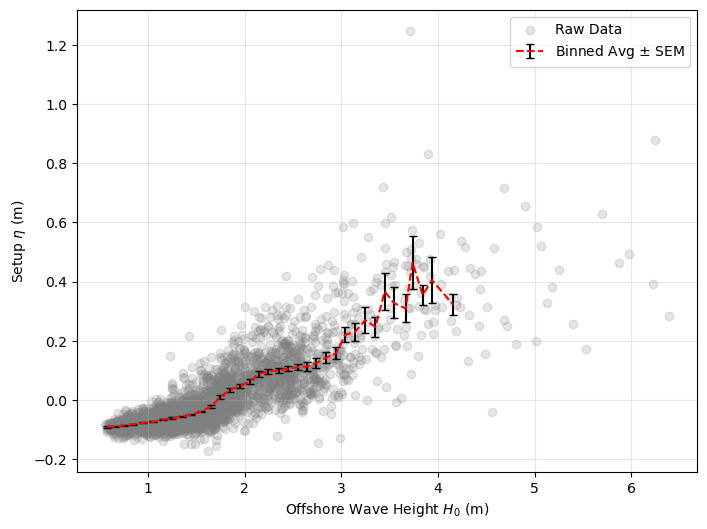

In [ ]:
binned_df = bin_stats(
    final_df, 
    x_col='H0', 
    y_col='n', 
    bin_size=0.1, 
    min_points=5  # MM mentioned removing noise, so requiring 5+ points helps
)

# Preview the result
print(binned_df.head())

# --- Quick Plotting Check ---


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 1. Plot original raw data (faintly)
plt.scatter(final_df['H0'], final_df['n'], alpha=0.2, c='gray', label='Raw Data')

# 2. Plot binned averages with Error Bars
plt.errorbar(
    binned_df['x_mean'], 
    binned_df['y_mean'], 
    yerr=binned_df['y_sem'], 
    fmt='--', 
    color='red', 
    ecolor='black', 
    capsize=3, 
    label='Binned Avg $\pm$ SEM'
)

plt.xlabel('Offshore Wave Height $H_0$ (m)')
plt.ylabel('Setup $\eta$ (m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Fit Results: y = 0.0923x + -0.1645
R^2: 0.993


<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_63952/607963225.py:48: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Setup $\eta$ (m)')


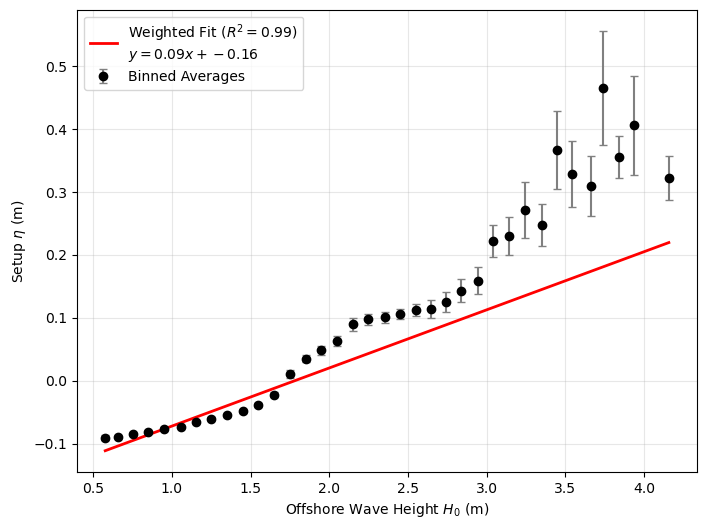

In [38]:
from scipy.optimize import curve_fit

# 1. Define the linear model
def linear_model(x, m, c):
    return m * x + c

# 2. Prepare data for fitting (drop bins with NaN errors if any)
fit_data = binned_df.dropna(subset=['y_sem'])
x_data = fit_data['x_mean']
y_data = fit_data['y_mean']
y_err  = fit_data['y_sem']

# 3. Perform Weighted Linear Regression
# sigma=y_err tells curve_fit to weight by 1/error^2
popt, pcov = curve_fit(linear_model, x_data, y_data, sigma=y_err, absolute_sigma=True)
m_fit, c_fit = popt
perr = np.sqrt(np.diag(pcov)) # Standard deviation of the parameters

# 4. Calculate R-squared (Weighted)
# We calculate how well the line predicts the BINNED means
residuals = y_data - linear_model(x_data, *popt)
ss_res = np.sum((residuals / y_err)**2)  # Weighted sum of squared residuals
ss_tot = np.sum(((y_data - np.mean(y_data)) / y_err)**2) # Weighted total sum of squares
r_squared = 1 - (ss_res / ss_tot)

# Alternative: Unweighted R^2 (Often preferred for simple visual checks)
# ss_res_simple = np.sum((y_data - linear_model(x_data, *popt))**2)
# ss_tot_simple = np.sum((y_data - np.mean(y_data))**2)
# r_squared_simple = 1 - (ss_res_simple / ss_tot_simple)

print(f"Fit Results: y = {m_fit:.4f}x + {c_fit:.4f}")
print(f"R^2: {r_squared:.3f}")

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Plot Binned Points with Error Bars
plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', color='black', 
             ecolor='gray', capsize=3, label='Binned Averages')

# Plot Best Fit Line
x_range = np.linspace(x_data.min(), x_data.max(), 100)
plt.plot(x_range, linear_model(x_range, m_fit, c_fit), 
         color='red', linewidth=2, 
         label=f'Weighted Fit ($R^2={r_squared:.2f}$)\n$y={m_fit:.2f}x + {c_fit:.2f}$')

plt.xlabel('Offshore Wave Height $H_0$ (m)')
plt.ylabel('Setup $\eta$ (m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()